/Users/aleksisormunen/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


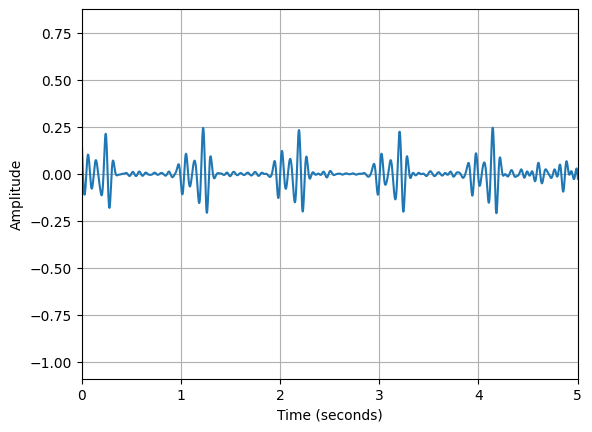

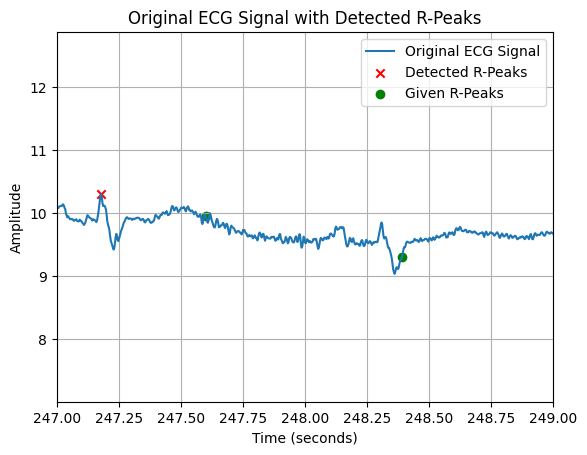

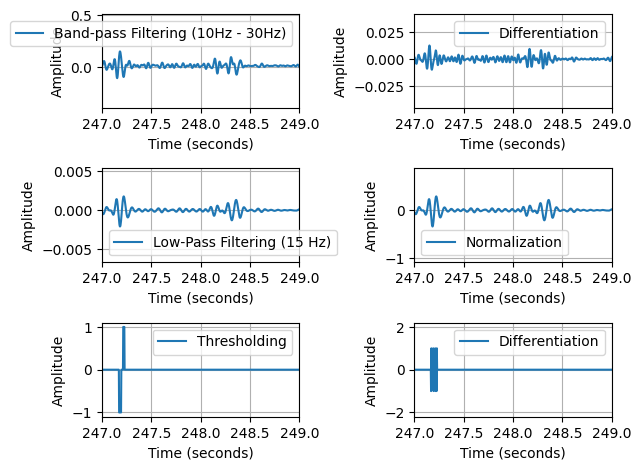

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

# Load ECG data
ecg = np.load("ecg.npz", allow_pickle=True)
data = ecg["data"]
sig_info = ecg["sig_info"][()]
r_peaks_given = sig_info['S1']['rspike'][:, 0]
ecg_signal = data[8, :]
fs = 360

# Band-Pass Filter the ECG signal (10 Hz - 30 Hz)
bandpass = signal.firwin(51, [10, 30], fs=fs, pass_zero='bandpass', window='hamming')
filtered_signal = signal.filtfilt(bandpass, 1, ecg_signal)


# Differentiate the signal
diff_signal = np.diff(filtered_signal, 2)

# Low-Pass Filter the signal (15 Hz)
lowpass = signal.firwin(51, 15, fs=fs, pass_zero='lowpass', window='hamming')
filtered_signal_second = signal.filtfilt(lowpass, 1, diff_signal)

# Normalize the signal
normalized_signal = filtered_signal_second / np.max(np.abs(filtered_signal_second))

# Plot the normalized signal to define threshold values
plt.figure()
time_axis = np.arange(len(normalized_signal)) / fs
plt.plot(time_axis, normalized_signal, label='PLotted normalized signal to define tresholds')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.grid()
plt.xlim([0, 5])
plt.show()

# Threshold the signal
pos_thresh = 0.25
neg_thresh = -0.22
thresholded_signal = np.zeros_like(normalized_signal)
thresholded_signal[normalized_signal > pos_thresh] = 1
thresholded_signal[normalized_signal < neg_thresh] = -1

# Differentiate the signal again
diff_signal_second = np.diff(thresholded_signal, 2)

# Find the QRS complexes
qrs_complexes = []
qrs_start = None
in_qrs = False
zero_count = int(fs * 0.3)  # Number of samples for 0.3 seconds
for i, value in enumerate(diff_signal_second):
    if np.any(value != 0) and not in_qrs:  # Checking if any element is non-zero
        qrs_start = i
        in_qrs = True
    elif in_qrs and np.all(value == 0):  # Checking if all elements are zero
        zero_count -= 1
        if zero_count <= 0:
            qrs_end = i
            qrs_complexes.append((qrs_start, qrs_end))
            in_qrs = False
            zero_count = int(fs * 0.3)  # Reset zero count for the next QRS

# Find the R-peaks out of the QRS-complexes
r_peaks = []
for qrs in qrs_complexes:
    qrs_signal = ecg_signal[qrs[0]:qrs[1]]
    r_peak_index = np.argmax(qrs_signal)
    r_peaks.append(qrs[0] + r_peak_index)

# Plot the results
plt.figure()
plt.plot(np.arange(len(ecg_signal)) / fs, ecg_signal, label='Original ECG Signal')
plt.scatter(np.array(r_peaks) / fs, ecg_signal[r_peaks], color='r', marker='x', label='Detected R-Peaks')
plt.scatter(r_peaks_given / fs, ecg_signal[r_peaks_given], color='g', marker='o', label='Given R-Peaks')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.legend()
plt.xlim([247, 249])
plt.title('Original ECG Signal with Detected R-Peaks')
plt.grid()
plt.show()

# Plot the images of detected and undetected peak in each of the steps
plt.figure()
plt.subplot(3, 2, 1)
time_axis = np.arange(len(filtered_signal)) / fs
plt.plot(time_axis, filtered_signal, label='Band-pass Filtering (10Hz - 30Hz)')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.grid()
plt.xlim([247, 249])
plt.legend()

plt.subplot(3, 2, 2)
time_axis = np.arange(len(diff_signal)) / fs
plt.plot(time_axis, diff_signal, label='Differentiation')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.grid()
plt.xlim([247, 249])
plt.legend()

plt.subplot(3, 2, 3)
time_axis = np.arange(len(filtered_signal_second)) / fs
plt.plot(time_axis, filtered_signal_second, label='Low-Pass Filtering (15 Hz)')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.grid()
plt.xlim([247, 249])
plt.legend()

plt.subplot(3, 2, 4)
time_axis = np.arange(len(normalized_signal)) / fs
plt.plot(time_axis, normalized_signal, label='Normalization')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.grid()
plt.xlim([247, 249])
plt.legend()

plt.subplot(3, 2, 5)
time_axis = np.arange(len(thresholded_signal)) / fs
plt.plot(time_axis, thresholded_signal, label='Thresholding')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.grid()
plt.xlim([247, 249])
plt.legend()

plt.subplot(3, 2, 6)
time_axis = np.arange(len(diff_signal_second)) / fs
plt.plot(time_axis, diff_signal_second, label='Differentiation')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.grid()
plt.xlim([247, 249])
plt.legend()
plt.tight_layout()
plt.show()